In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as sts
import matplotlib.image as mpimg

# import seaborn as sns

# sns.set(rc={'figure.figsize':(18, 10)})
# sns.set_style("whitegrid")

def read_gro(file):
    df = []
    with open(file) as file:
        for cnt, line in enumerate(file):
            if (cnt > 1) and len(line) >= 40:
                df.append([line[0:5], line[5:10].strip(), line[10:15].strip(),
                           line[15:20], line[20:28], line[28:36], line[36:44]])
            elif len(line.split()) == 3:
                box = line
    df = pd.DataFrame(df, columns=('resnum', 'res', 'atom', 'atnum', 'x', 'y', 'z'))        
    return df.astype({'atnum': np.uint32, 'resnum': np.uint32, 'atom': str, 'x': float, 'y': float, 'z': float}), box


def read_gro_set_bond(file):
    df, box = read_gro(file)
    box = np.array(box.split(), dtype=np.float32)
    df['attype'] = df.atom.apply(lambda x: x[0])
    masses = {'H': 1, 'O': 16, 'C': 12, 'N': 14, 'S': 32, 'Z': 65}
    df['m'] = df.attype.apply(lambda x: masses[x])
    df.loc[df.x < 0, 'x'] += box[0]
    df.loc[df.y < 0, 'y'] += box[1]
    df.loc[df.z < 0, 'z'] += box[2]

    df.loc[df.x > box[0], 'x'] -= box[0]
    df.loc[df.y > box[1], 'y'] -= box[1]
    df.loc[df.z > box[2], 'z'] -= box[2]
    return df


def calc_p(df, nbin=100):
    gg = df[['x', 'y', 'z']].max() - df[['x', 'y', 'z']].min()
    
    df['bin'] = pd.cut(df.z, bins=nbin)
    v = df.bin.iloc[0].length * gg[0] * gg[1]
    gg = df.groupby('bin').agg(
                            m=('m', 'sum')
                            ).reset_index()
    
    gg['p'] = gg['m'] / v * 1.66
    gg['z'] = gg.bin.apply(lambda x: x.mid).astype(np.float32)
    return gg


def add_norm(p):
    m = p.m.sum()
    p['m'] /= m
    E = (p.m * p.z).sum()
    Ex2 = (p.m * p.z**2).sum()
    std = (Ex2 - E**2) ** 0.5
    a = sts.norm(E, std)
    x = np.linspace(E - 3*std, E + 3*std, 100)
    prob = a.pdf(x)
    # print(p.p.max() / prob.max(), p.p.sum())
    prob *= p.p.max() / prob.max()
    return x, prob

AMA_W
   4.161 878.542
AMA_sZ
   5.751 916.416
AMA_eU
   7.487 893.725
KMA_W
   4.855 921.668
MMA_W
   4.995 907.784
Mixed_W
   4.322 887.950
Mixed_eU
   5.759 917.387


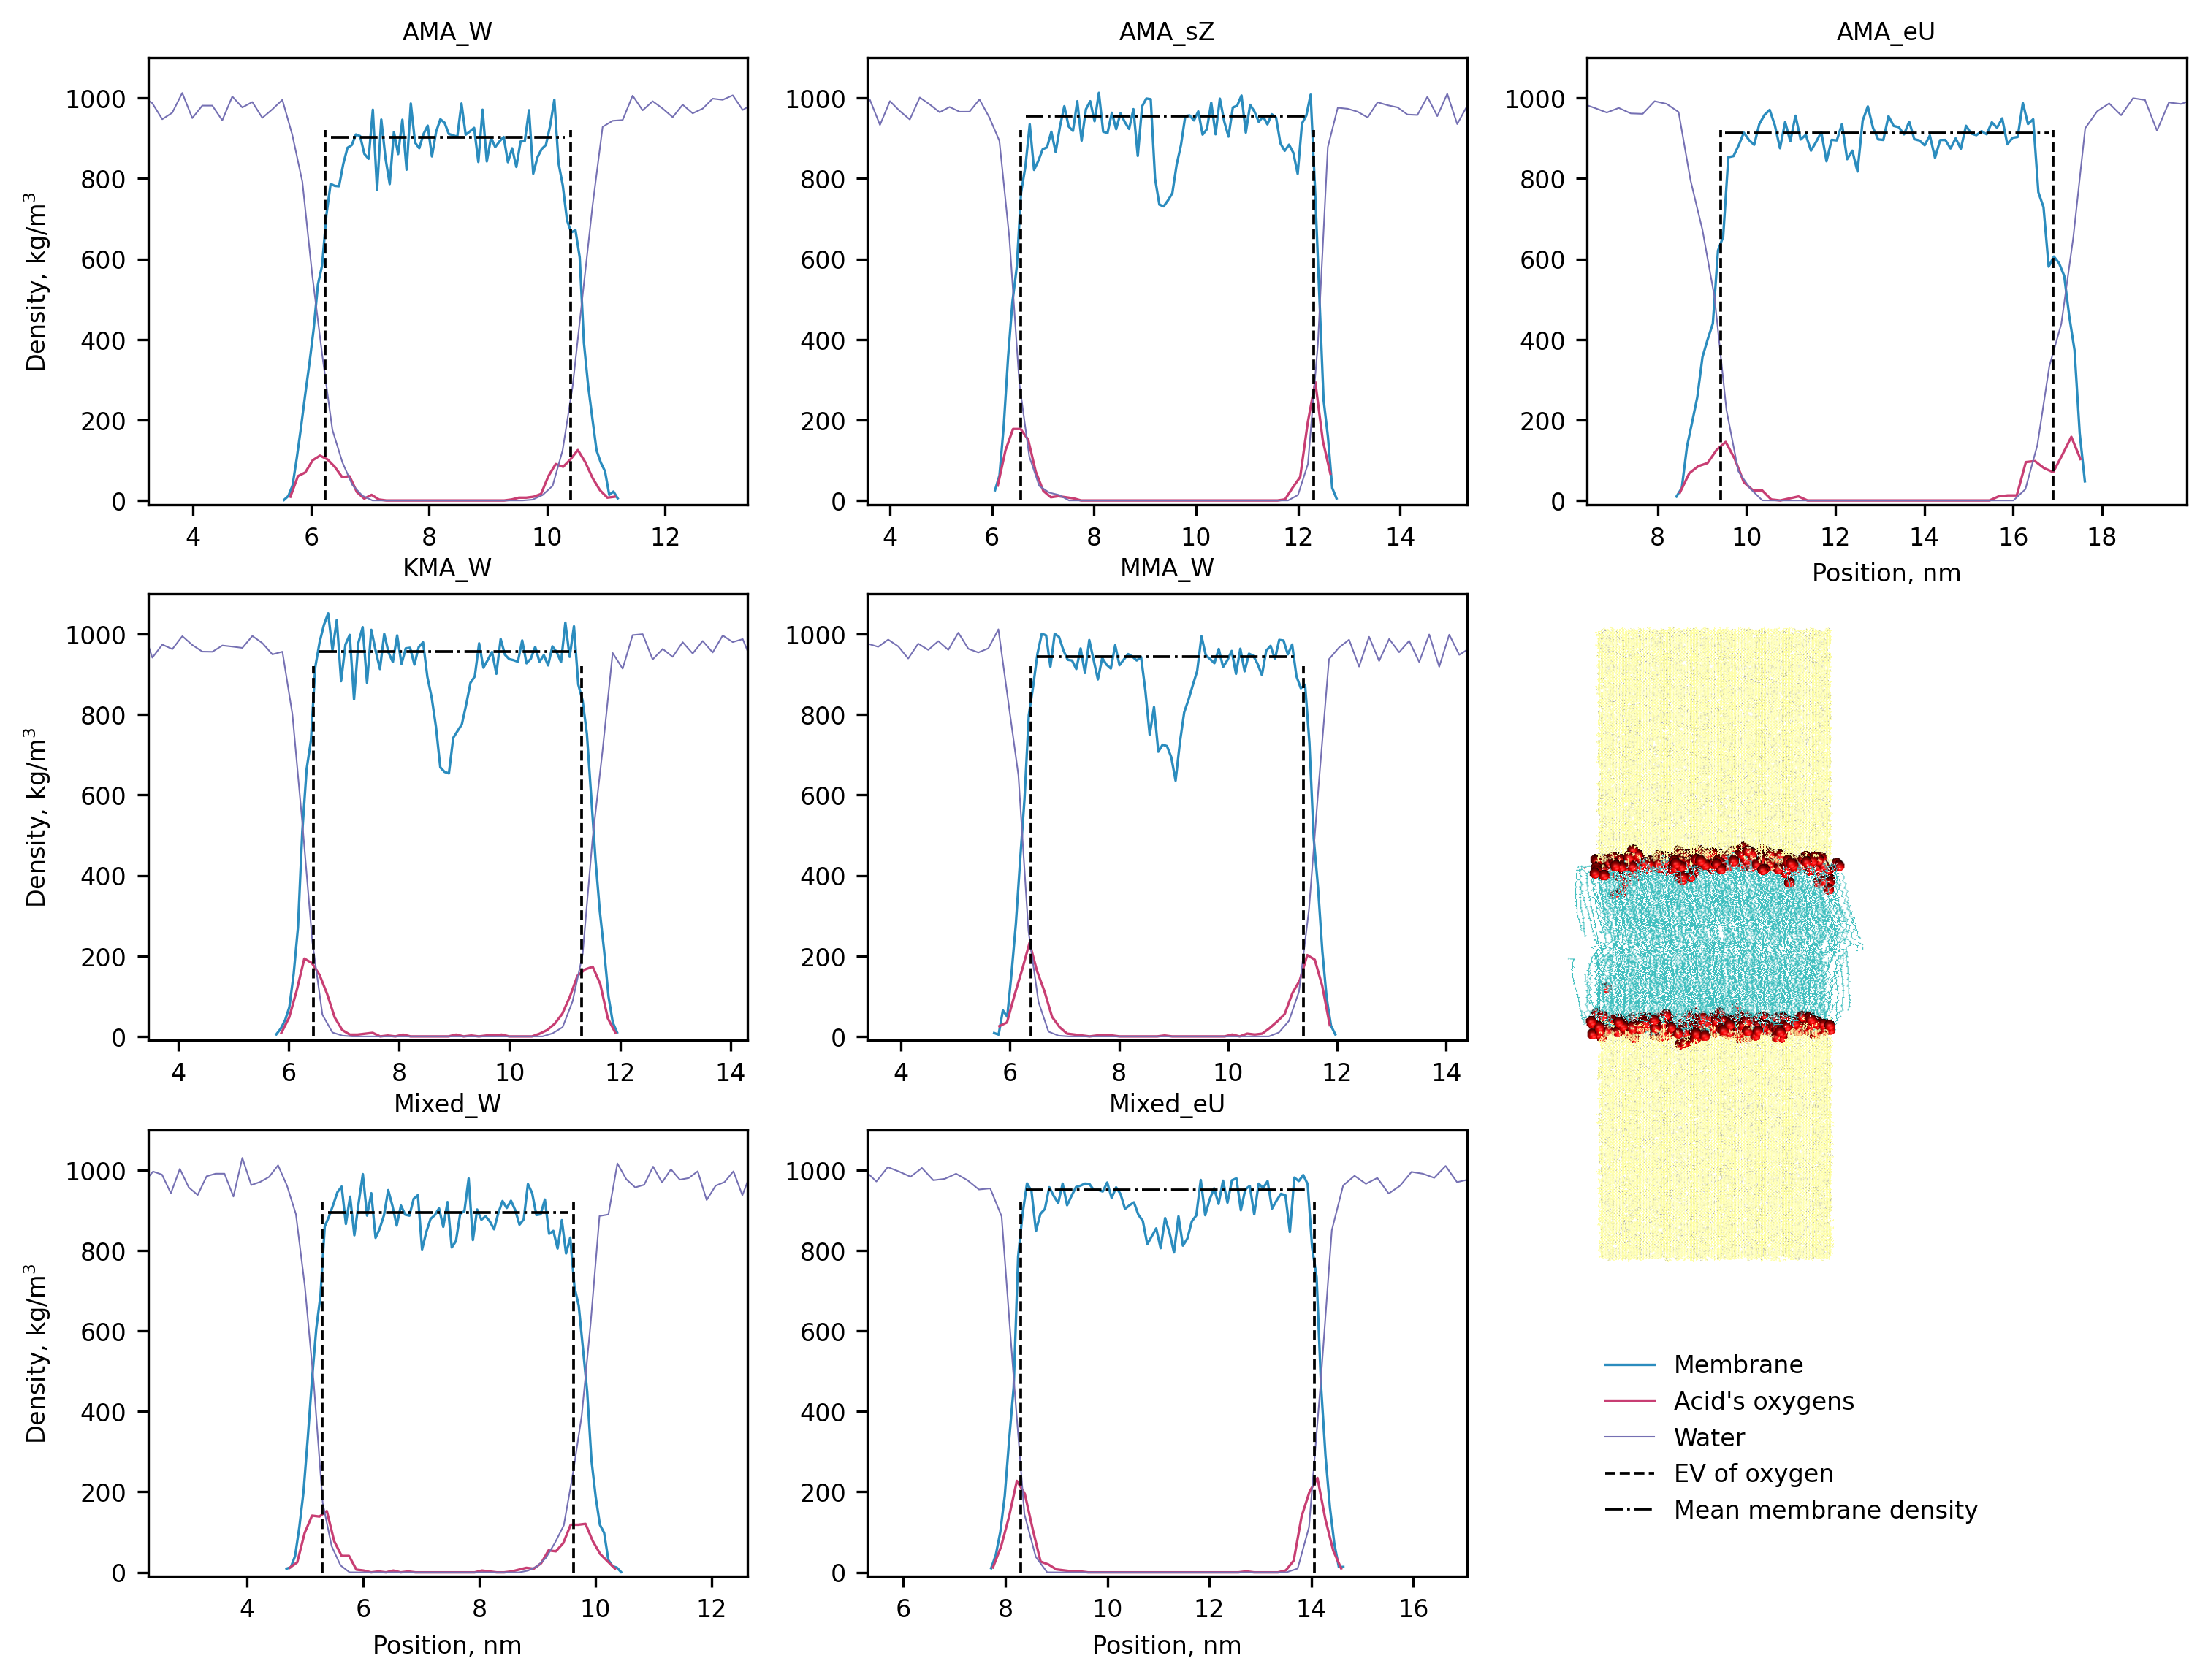

In [5]:
def add_plot(df, ax, font_style):
    c = ['#1b9e77','#c83e73','#7570b3','#e7298a']
    w = ['#f1eef6','#d0d1e6','#a6bddb','#74a9cf','#2b8cbe','#045a8d']
    colors = {
            'mem': w[-2],
            'wat': c[2],
            'oxygen': c[1],
            'normal': c[3],
            'E': 'black',
            }


    p_mem = calc_p(df[df.res !='SOL'].copy(), 80)
    p_ox = calc_p(df[(df.res != 'SOL') & (df.atom.str.startswith('O'))].copy(), 45)
    p_wat = calc_p(df[df.res == 'SOL'].copy(), 100)

    marker_line = {'markersize':3, 'linewidth': 0.8}
    ax.plot(p_mem.z, p_mem.p, '-', color=colors['mem'], label='Membrane', **marker_line)
    ax.plot(p_ox.z, p_ox.p, '-', color=colors['oxygen'], label="Acid's oxygens", **marker_line)
    ax.plot(p_wat.z, p_wat.p, linewidth=0.5, color=colors['wat'], label='Water')

    x0, prob = add_norm(p_ox[p_ox.z < p_ox.z.mean()].copy())
    # ax.plot(x, prob, linestyle='--', color=colors['normal'])
    ax.vlines(x0.mean(), 0, 920, linestyles='--', color=colors['E'], label='EV of oxygen', linewidth=0.9)

    x1, prob = add_norm(p_ox[p_ox.z > p_ox.z.mean()].copy())
    # ax.plot(x, prob, linestyle='--', color=colors['normal'])
    ax.vlines(x1.mean(), 0, 920, linestyles='--', color=colors['E'], linewidth=0.9)

    

    

    ax.set_xlabel('Position, nm', **font_style)
    ax.set_ylabel(r'Density, kg/m$^3$', **font_style)

    ax.set_xticks(np.arange(0, 20, 2))
    ax.set_yticks(ax.get_yticks())

    ax.set_xticklabels(list(map(lambda x: str(int(x)), np.arange(0, 20, 2))), **font_style)
    ax.set_yticklabels(list(map(lambda x: str(int(x)), ax.get_yticks())), **font_style)
    
    ax.hlines(p_mem.p.quantile(0.7), x0.mean()+0.1, x1.mean()-0.1, linestyles=['dashdot'], color='black', label='Mean membrane density', linewidth=0.9)
    ax.set_xlim(x0.mean() - 3, x1.mean() + 3)
    
    print ('{:8.3f}{:8.3f}'.format(x1.mean() - x0.mean(), p_mem.query('z > {} and z < {}'.format(x0.mean(), x1.mean())).p.mean()))


fig, ax = plt.subplots(3, 3, figsize=(12, 9), dpi=300)
font_style = {'fontsize': 8}

df = read_gro_set_bond(f'files/AMA_W.gro')
print('AMA_W') 
add_plot(df, ax[0, 0], font_style)

df = read_gro_set_bond(f'files/AMA_sZ.gro') 
print('AMA_sZ') 
add_plot(df, ax[0, 1], font_style)

df = read_gro_set_bond(f'files/AMA_eU.gro')
print('AMA_eU') 
add_plot(df, ax[0, 2], font_style)

df = read_gro_set_bond(f'files/KMA_W.gro') 
print('KMA_W') 
add_plot(df, ax[1, 0], font_style)

df = read_gro_set_bond(f'files/MMA_W.gro') 
print('MMA_W') 
add_plot(df, ax[1, 1], font_style)


df = read_gro_set_bond(f'files/Mixed_W.gro')
print('Mixed_W') 
add_plot(df, ax[2, 0], font_style)

df = read_gro_set_bond(f'files/Mixed_eU.gro') 
print('Mixed_eU') 
add_plot(df, ax[2, 1], font_style)

for i in range(3):
    for j in range(1, 3):
        ax[i, j].set_ylabel('')

titles = ['AMA_W', 'AMA_sZ', 'AMA_eU', 'KMA_W', 'MMA_W', '', 'Mixed_W', 'Mixed_eU', '']

n = 0
for i in range(3):
    for j in range(3):
        ax[i, j].set_ylim(-10, 1100)
        ax[i, j].set_title(titles[n], **font_style)
        n += 1

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('')


# ax[1, 2].remove()
img = mpimg.imread('plot/membrana.png')
for i in ax[1, 2].spines:
    ax[1, 2].spines[i].set_color('white')

ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])
box = ax[1, 2].get_position()
ax[1, 2].set_position([box.x0-0.12, box.y0-0.12, box.width*1.5, box.height*1.5])

ax[1, 2].imshow(img)
ax[1, 2].set_ylim([0, img.shape[0]])
ax[1, 2].set_xlim([0, img.shape[1]])

ax[2, 2].remove()

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center', bbox_to_anchor=[0.75, 0.18], frameon=False, ncol=1, **font_style)